# Multi-Agent System with LangGraph
In multi-agent systems, agents interact through handoffs, a mechanism that determines which agent receives control and what data is transferred to them.

Popular multi-agent architectures include:

-  **Supervisor:** A central supervisor agent oversees individual agents, managing all communication and task delegation. It decides which agent to activate based on the current context and task needs.
-  **Swarm:** Agents dynamically transfer control to one another based on their expertise. The system tracks the last active agent to ensure subsequent interactions continue with that agent.

**Overview of the `multi_agent_prebuilt.py` script:**

This script showcases three distinct approaches to building multi-agent systems:
1. **Supervisor Pattern:** A central supervisor agent assigns tasks to specialized agents.
2. **Swarm Pattern:** Agents directly pass tasks to each other as needed.
3. **Custom Handoffs:** A detailed implementation of task handoffs between agents.

In [152]:
# Import the os module to interact with the operating system, used here for environment variables.
import os
from dotenv import load_dotenv
from rich import print
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from IPython.display import Image, display
from langchain_core.tools import tool
load_dotenv()

True

## Section 1: Supervisor Multi-Agent System

This example demonstrates a supervisor-worker architecture. A `supervisor` agent receives a user request and routes it to the appropriate specialized agent (`flight_assistant` or `hotel_assistant`).

**Code Logic:**
1.  **Tool Definition:** Simple functions `book_hotel` and `book_flight` are defined as tools for the agents.
2.  **Agent Creation:** Two `create_react_agent` instances are created. Each agent is specialized for a single task (booking flights or hotels) and is given access to the relevant tool.
3.  **Supervisor Creation:** `create_supervisor` is used to create a managing agent that orchestrates the two specialized agents.
4.  **Execution:** The system is run by streaming a user request through the compiled supervisor graph.

In [153]:
# Define a tool function for booking a hotel.
# It takes the hotel name as input and returns a confirmation message.
@tool
def book_hotel(hotel_name: str):
    """Book a hotel"""
    # This is a mock function; in a real application, this would
    # interact with a hotel booking API.
    return f'Successfully booked a stay at {hotel_name}.'


# Define a tool function for booking a flight.
# It takes departure and arrival airports and returns a confirmation.
@tool
def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    # This is a mock function; in a real application, this would
    # interact with a flight booking API.
    return f'Successfully booked a flight from {from_airport} to {to_airport}.'

In [154]:
# Create the first specialized agent for booking flights.
# The create_react_agent function initializes an agent that can reason and act.
flight_assistant = create_react_agent(
    # The language model that powers the agent's reasoning.
    model=ChatOpenAI(model='gpt-4o-mini', max_tokens=500),
    # The list of tools the agent can use. This agent can only book flights.
    tools=[book_flight],
    # The system prompt that defines the agent's role and personality.
    prompt='You are a flight booking assistant. Help users book flights.',
    # A unique name for the agent, used for routing and identification.
    name='flight_assistant',
)


# Create the second specialized agent for booking hotels.
hotel_assistant = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini', max_tokens=500),
    # This agent can only use the book_hotel tool.
    tools=[book_hotel],
    # The specific prompt for the hotel assistant.
    prompt='You are a hotel booking assistant. Help users book hotels.',
    # A unique name for the hotel agent.
    name='hotel_assistant',
)

In [155]:
# Create the supervisor agent that will manage the specialized agents.
# The create_supervisor function wires together the agents and a routing mechanism.
supervisor = create_supervisor(
    # A list of the worker agents that the supervisor can delegate tasks to.
    agents=[flight_assistant, hotel_assistant],
    # The language model for the supervisor's decision-making.
    model=ChatOpenAI(model='gpt-4o-mini', max_tokens=500),
    # The system prompt for the supervisor, defining its role as a manager.
    prompt='You manage hotel and flight booking assistants. Assign work to them.',
    # Compile the supervisor graph into a runnable LangGraph object.
).compile()

Subgraph structure:

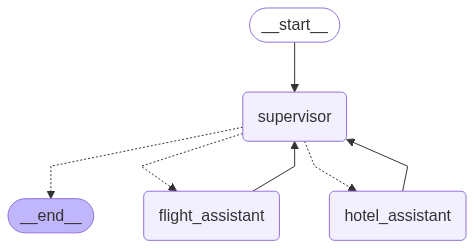

In [156]:
# Print a header to indicate that the graph structure is being displayed.
print('Subgraph structure:')
try:
    display(Image(supervisor.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [157]:
# Print a header for the supervisor example output.
print('=== SUPERVISOR EXAMPLE ===')

# Stream the output from the supervisor graph for a given user request.
# The `stream` method allows processing the output as it's generated.
# `debug=True` provides verbose logging of the internal steps.
for chunk in supervisor.stream(
    # The input to the graph is a dictionary with a 'messages' key.
    {'messages': [{'role': 'user', 'content': 'Book a flight from LAX to NYC'}]},
    debug=True,
):
    # Check if the chunk contains any data before printing.
    if chunk:
        # Print a separator for readability.
        print('-' * 60)
        # Print the content of the current chunk.
        # print(f'Chunk: {chunk}')
        # The original print(chunk) is commented out, but can be used for raw output.
        print(chunk)

=== SUPERVISOR EXAMPLE ===

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='bcda27db-1f65-4b6d-896e-65ece36956af')]}
[updates] {'supervisor': {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='bcda27db-1f65-4b6d-896e-65ece36956af'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCcy1beSgwwufDdZMYUwelUkUvCvj', 'service_

------------------------------------------------------------

{
    'supervisor': {
        'messages': [
            HumanMessage(
                content='Book a flight from LAX to NYC',
                additional_kwargs={},
                response_metadata={},
                id='bcda27db-1f65-4b6d-896e-65ece36956af'
            ),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK',
                            'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'},
                            'type': 'function'
                        }
                    ],
                    'refusal': None
                },
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 14,
                        'prompt_tokens': 88,
                        'total_tokens': 102,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCcy1beSgwwufDdZMYUwelUkUvCvj',
                    'service_tier': 'default',
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                name='supervisor',
                id='run--2642cb53-4610-400c-b956-e078048a0bbe-0',
                tool_calls=[
                    {
                        'name': 'transfer_to_flight_assistant',
                        'args': {},
                        'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 88,
                    'output_tokens': 14,
                    'total_tokens': 102,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            ),
            ToolMessage(
                content='Successfully transferred to flight_assistant',
                name='transfer_to_flight_assistant',
                id='d8a7c030-152a-4003-bec1-321484fe98f8',
                tool_call_id='call_hIenGOUhVyKhHpw4WzVcJ7nK'
            )
        ]
    }
}

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='bcda27db-1f65-4b6d-896e-65ece36956af'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCcy1beSgwwufDdZMYUwelUkUvCvj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--2642cb53-4610-400c-b956-e078048a0bbe-0', tool_calls=[{'name': 'transfer_to_flight_assi

------------------------------------------------------------

{
    'flight_assistant': {
        'messages': [
            AIMessage(
                content='Your flight from LAX to NYC has been successfully booked. Safe travels!',
                additional_kwargs={'refusal': None},
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 16,
                        'prompt_tokens': 153,
                        'total_tokens': 169,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCcy2vcgoVSO7TIe32fA063ukX0iW',
                    'service_tier': 'default',
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                name='flight_assistant',
                id='run--00a00943-e24a-47a1-ba2f-93f2db52751a-0',
                usage_metadata={
                    'input_tokens': 153,
                    'output_tokens': 16,
                    'total_tokens': 169,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            ),
            AIMessage(
                content='Transferring back to supervisor',
                additional_kwargs={},
                response_metadata={'__is_handoff_back': True},
                name='flight_assistant',
                id='eb8d4263-9a41-47cb-b93f-61105e7f2aa9',
                tool_calls=[
                    {
                        'name': 'transfer_back_to_supervisor',
                        'args': {},
                        'id': 'e16e9062-891a-435f-b096-66becfd85b44',
                        'type': 'tool_call'
                    }
                ]
            ),
            ToolMessage(
                content='Successfully transferred back to supervisor',
                name='transfer_back_to_supervisor',
                id='8323a110-8440-4c9c-a3c3-8f316c6dcc56',
                tool_call_id='e16e9062-891a-435f-b096-66becfd85b44'
            )
        ]
    }
}

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='bcda27db-1f65-4b6d-896e-65ece36956af'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCcy1beSgwwufDdZMYUwelUkUvCvj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--2642cb53-4610-400c-b956-e078048a0bbe-0', tool_calls=[{'name': 'transfer_to_flight_assi

------------------------------------------------------------

{
    'supervisor': {
        'messages': [
            HumanMessage(
                content='Book a flight from LAX to NYC',
                additional_kwargs={},
                response_metadata={},
                id='bcda27db-1f65-4b6d-896e-65ece36956af'
            ),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK',
                            'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'},
                            'type': 'function'
                        }
                    ],
                    'refusal': None
                },
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 14,
                        'prompt_tokens': 88,
                        'total_tokens': 102,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCcy1beSgwwufDdZMYUwelUkUvCvj',
                    'service_tier': 'default',
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                name='supervisor',
                id='run--2642cb53-4610-400c-b956-e078048a0bbe-0',
                tool_calls=[
                    {
                        'name': 'transfer_to_flight_assistant',
                        'args': {},
                        'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 88,
                    'output_tokens': 14,
                    'total_tokens': 102,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            ),
            ToolMessage(
                content='Successfully transferred to flight_assistant',
                name='transfer_to_flight_assistant',
                id='d8a7c030-152a-4003-bec1-321484fe98f8',
                tool_call_id='call_hIenGOUhVyKhHpw4WzVcJ7nK'
            ),
            AIMessage(
                content='Your flight from LAX to NYC has been successfully booked. Safe travels!',
                additional_kwargs={'refusal': None},
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 16,
                        'prompt_tokens': 153,
                        'total_tokens': 169,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCcy2vcgoVSO7TIe32fA063ukX0iW',
                    'service_tier': 'default',
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                name='flight_assistant',
                id='run--00a00943-e24a-47a1-ba2f-93f2db52751a-0',
                usage_metad

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='bcda27db-1f65-4b6d-896e-65ece36956af'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hIenGOUhVyKhHpw4WzVcJ7nK', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCcy1beSgwwufDdZMYUwelUkUvCvj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--2642cb53-4610-400c-b956-e078048a0bbe-0', tool_calls=[{'name': 'transfer_to_flight_assi

## Section 2: Swarm Multi-Agent System - Research & Writing Collaboration

This example showcases a swarm architecture where agents collaborate on research and content creation tasks. Agents can directly hand off tasks to one another based on their expertise, creating a dynamic collaborative workflow.

**Code Logic:**
1.  **Tool Definition:** Research tools (`conduct_research`, `create_outline`) and writing tools (`write_content`, `edit_content`) are defined for specialized agents.
2.  **Handoff Tool Creation:** `create_handoff_tool` is used to create special tools that allow agents to transfer control to one another based on task requirements.
3.  **Agent Creation:** Specialized agents (researcher, writer, editor) are created with their primary tools and handoff capabilities.
4.  **Swarm Creation:** `create_swarm` assembles the agents into a collaborative system where they can seamlessly pass work between each other.
5.  **Execution:** The user request is streamed through the swarm, demonstrating how agents collaborate on complex multi-step tasks.

In [158]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_swarm, create_handoff_tool

In [159]:
# Define a tool for conducting research on a given topic.
@tool
def conduct_research(topic: str):
    """Conduct research on a given topic"""
    # This is a mock function; in a real application, this would
    # interact with research APIs, databases, or web scraping tools.
    return f'Research completed on "{topic}". Found key insights: market trends, best practices, and recent developments.'


# Define a tool for creating content outlines.
@tool
def create_outline(topic: str, research_findings: str):
    """Create a structured outline based on research findings"""
    # This would typically use the research findings to structure content
    return f'Outline created for "{topic}" with sections: Introduction, Key Points from research, Analysis, and Conclusion.'


# Define a tool for writing content based on an outline.
@tool
def write_content(topic: str, outline: str):
    """Write content based on the provided outline"""
    return f'Content written for "{topic}" following the provided outline structure.'


# Define a tool for editing and refining content.
@tool
def edit_content(content: str):
    """Edit and refine the provided content"""
    return f'Content has been edited and refined for clarity, grammar, and flow.'

In [160]:
# Create a handoff tool that allows transferring a task to the writer agent.
# The `create_handoff_tool` function generates a tool that agents can call.
transfer_to_writer = create_handoff_tool(
    # The name of the agent to hand off to.
    agent_name='writer_assistant',
    # The description of the tool, which the agent's LLM will use to decide when to use it.
    description='Transfer to content writer assistant for creating articles and documents.',
)


# Create a handoff tool for transferring to the editor agent.
transfer_to_editor = create_handoff_tool(
    agent_name='editor_assistant',
    description='Transfer to content editor assistant for reviewing and refining content.',
)


# Create a handoff tool for transferring back to the researcher agent.
transfer_to_researcher = create_handoff_tool(
    agent_name='researcher_assistant',
    description='Transfer to research assistant for gathering information and insights.',
)

In [161]:
# Create the researcher assistant for the swarm.
researcher_assistant_swarm = create_react_agent(
    model=ChatOpenAI(model='gpt-4o', max_tokens=1000, temperature=0),
    # This agent has research tools and can hand off to writer and editor.
    tools=[conduct_research, create_outline, transfer_to_writer, transfer_to_editor],
    prompt='You are a research assistant. You conduct thorough research on topics and create structured outlines. When research is complete, you can transfer to the writer or editor as needed.',
    name='researcher_assistant',
)


# Create the writer assistant for the swarm.
writer_assistant_swarm = create_react_agent(
    model=ChatOpenAI(model='gpt-4o', max_tokens=1000, temperature=0),
    # This agent can write content and hand off to researcher or editor.
    tools=[write_content, transfer_to_researcher, transfer_to_editor],
    prompt='You are a content writer. You create well-structured articles and documents based on research and outlines. You can request additional research or transfer to an editor for refinement.',
    name='writer_assistant',
)


# Create the editor assistant for the swarm.
editor_assistant_swarm = create_react_agent(
    model=ChatOpenAI(model='gpt-4o', max_tokens=1000, temperature=0),
    # This agent can edit content and hand off to researcher or writer.
    tools=[edit_content, transfer_to_researcher, transfer_to_writer],
    prompt='You are a content editor. You review, refine, and improve written content for clarity, accuracy, and engagement. You can request additional research or writing as needed.',
    name='editor_assistant',
)

In [162]:
# Create the swarm by passing the list of research and writing agents.
# `create_swarm` wires them together so they can hand off tasks to each other.
# `default_active_agent` specifies which agent should receive the initial request (if no agents are currently active).
swarm = create_swarm(
    agents=[researcher_assistant_swarm, writer_assistant_swarm, editor_assistant_swarm], 
    default_active_agent='researcher_assistant'
).compile()

In [163]:
# print('Subgraph structure:')
# try:
#     display(Image(swarm.get_graph().draw_mermaid_png()))
# except Exception:
#     pass

In [164]:
print('\n=== SWARM EXAMPLE - RESEARCH & WRITING COLLABORATION ===')

# The request asks for a complete article workflow: research, writing, and editing.The researcher will start, then likely hand off to the writer, who may then pass to the editor.
for chunk in swarm.stream({
    'messages': [{'role': 'user', 'content': 'Create a comprehensive article about the benefits of artificial intelligence in healthcare. Please research the topic, write the content, and then edit it for publication.'}]
}, debug=True):
    if chunk:
        print('-' * 60)
        # print(f'Chunk: {chunk}')
        # print tool calls and responses
        # print(chunk)

=== SWARM EXAMPLE - RESEARCH & WRITING COLLABORATION ===

[values] {'messages': [HumanMessage(content='Create a comprehensive article about the benefits of artificial intelligence in healthcare. Please research the topic, write the content, and then edit it for publication.', additional_kwargs={}, response_metadata={}, id='66d68038-17b2-436e-9add-31ef15f165c4')]}
[updates] {'researcher_assistant': {'messages': [HumanMessage(content='Create a comprehensive article about the benefits of artificial intelligence in healthcare. Please research the topic, write the content, and then edit it for publication.', additional_kwargs={}, response_metadata={}, id='66d68038-17b2-436e-9add-31ef15f165c4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Cw0RrE5Eucon4CjHR5HxTTe3', 'function': {'arguments': '{"topic":"benefits of artificial intelligence in healthcare"}', 'name': 'conduct_research'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 180, 'total_tokens': 202, 

------------------------------------------------------------

[values] {'messages': [HumanMessage(content='Create a comprehensive article about the benefits of artificial intelligence in healthcare. Please research the topic, write the content, and then edit it for publication.', additional_kwargs={}, response_metadata={}, id='66d68038-17b2-436e-9add-31ef15f165c4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Cw0RrE5Eucon4CjHR5HxTTe3', 'function': {'arguments': '{"topic":"benefits of artificial intelligence in healthcare"}', 'name': 'conduct_research'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 180, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCcy4rClbZsoJjxJ6K4OnvEd8GQHK', 'servi

------------------------------------------------------------

[values] {'messages': [HumanMessage(content='Create a comprehensive article about the benefits of artificial intelligence in healthcare. Please research the topic, write the content, and then edit it for publication.', additional_kwargs={}, response_metadata={}, id='66d68038-17b2-436e-9add-31ef15f165c4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Cw0RrE5Eucon4CjHR5HxTTe3', 'function': {'arguments': '{"topic":"benefits of artificial intelligence in healthcare"}', 'name': 'conduct_research'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 180, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCcy4rClbZsoJjxJ6K4OnvEd8GQHK', 'servi

------------------------------------------------------------

[values] {'messages': [HumanMessage(content='Create a comprehensive article about the benefits of artificial intelligence in healthcare. Please research the topic, write the content, and then edit it for publication.', additional_kwargs={}, response_metadata={}, id='66d68038-17b2-436e-9add-31ef15f165c4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Cw0RrE5Eucon4CjHR5HxTTe3', 'function': {'arguments': '{"topic":"benefits of artificial intelligence in healthcare"}', 'name': 'conduct_research'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 180, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCcy4rClbZsoJjxJ6K4OnvEd8GQHK', 'servi

## Section 3: Custom Handoffs Implementation

This section provides a from-scratch implementation of handoffs, giving you complete control over agent interaction logic. It uses a `StateGraph` to define the workflow explicitly.

You can specify:
- **destination**: target agent to navigate to
- **payload**: information to pass to that agent

**Code Logic:**
1. **Tool Definition:** `book_hotel_custom` and `book_flight_custom` tools are defined.
2. **Custom Handoff Tool Factory:** The `create_handoff_tool` function generates a tool that returns a `Command` object when called. This `Command` instructs the graph to transition to a different agent node.
3. **Agent Definition:** Agents are created with their respective tools, including the custom handoff tools.
4. **Graph Building:** A `StateGraph` is constructed with agents added as nodes and an entry point (`START`) that directs initial requests to the `flight_assistant`.


In [173]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

In [166]:
# Define a custom tool for booking a hotel.
@tool
def book_hotel_custom(hotel_name: str):
    """Book a hotel"""
    return f'Custom hotel booking: {hotel_name}'


# Define a custom tool for booking a flight.
@tool
def book_flight_custom(from_airport: str, to_airport: str):
    """Book a flight"""
    return f'Custom flight booking: {from_airport} to {to_airport}'

In [ ]:
# This function is a factory for creating custom handoff tools.
def create_handoff_tool_custom(*, agent_name: str, description: str):
    # Generate a unique name for the tool based on the target agent.
    name = f'transfer_to_{agent_name}'

    # Use the @tool decorator to define the handoff tool.
    @tool(name, description=description)
    def handoff_tool(state: Annotated[MessagesState, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        # Create a tool message to record the handoff event.
        tool_message = {
            'role': 'tool',
            'content': f'Transferred to {agent_name}',
            'name': name,
            'tool_call_id': tool_call_id,
        }
        # Return a Command object to instruct the graph to transition.
        return Command(
            # The `goto` field specifies the next node to execute.
            goto=agent_name,
            # The `update` field modifies the state, adding the tool message.
            update={'messages': state['messages'] + [tool_message]},
            # `graph=Command.PARENT` indicates the command applies to the parent graph.
            graph=Command.PARENT,
        )

    return handoff_tool

In [174]:
# Create the custom handoff tools using the factory function.
transfer_to_hotel_custom = create_handoff_tool_custom(
    agent_name='hotel_assistant',
    description='Transfer to hotel assistant.',
)

transfer_to_flight_custom = create_handoff_tool_custom(
    agent_name='flight_assistant',
    description='Transfer to flight assistant.',
)

In [178]:
# Define the agents using the custom tools.
flight_assistant_custom = create_react_agent(
    model=ChatOpenAI(model='gpt-4o', max_tokens=1000),
    tools=[book_flight_custom, transfer_to_hotel_custom],
    prompt='You are a flight booking assistant.',
    name='flight_assistant',
)

hotel_assistant_custom = create_react_agent(
    model=ChatOpenAI(model='gpt-4o', max_tokens=1000),
    tools=[book_hotel_custom, transfer_to_flight_custom],
    prompt='You are a hotel booking assistant.',
    name='hotel_assistant',
)

In [179]:
# Build the state graph manually. New way to define multi-agent workflows.
multi_agent_graph = (
    # Initialize a StateGraph with the MessagesState schema.
    StateGraph(MessagesState)
    .add_node('flight_assistant', flight_assistant_custom)
    # Add the hotel assistant as another node.
    .add_node('hotel_assistant', hotel_assistant_custom)
    # Define the entry point of the graph. All requests will start at the flight assistant.
    .add_edge(START, 'flight_assistant')
    .compile()
)

Subgraph structure:

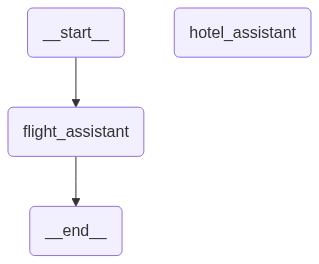

In [180]:
print('Subgraph structure:')
try:
    img = Image(multi_agent_graph.get_graph().draw_mermaid_png())
    display(img)
except Exception:
    pass

In [181]:
# Print a header for the custom handoffs example.
print('\n=== CUSTOM HANDOFFS EXAMPLE ===')

# Stream the output from the custom graph.
for chunk in multi_agent_graph.stream(
    {'messages': [{'role': 'user', 'content': 'Book a flight from SFO to LAX and book me a hotel in SF'}]}, debug=True
):
    if chunk:
        print('-' * 60)
        # print(f'Chunk: {chunk}')
        # print(chunk)

=== CUSTOM HANDOFFS EXAMPLE ===

[values] {'messages': [HumanMessage(content='Book a flight from SFO to LAX and book me a hotel in SF', additional_kwargs={}, response_metadata={}, id='e6593ffb-20f3-4dbe-acb4-a1cb5209abd3')]}
[updates] {'flight_assistant': {'messages': [HumanMessage(content='Book a flight from SFO to LAX and book me a hotel in SF', additional_kwargs={}, response_metadata={}, id='e6593ffb-20f3-4dbe-acb4-a1cb5209abd3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7iZWQVDhuLU9n5CDWvb81Gbs', 'function': {'arguments': '{"from_airport": "SFO", "to_airport": "LAX"}', 'name': 'book_flight_custom'}, 'type': 'function'}, {'id': 'call_wvb2qXsQEZzVG30XwiSBowhL', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 91, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_pred

------------------------------------------------------------

[values] {'messages': [HumanMessage(content='Book a flight from SFO to LAX and book me a hotel in SF', additional_kwargs={}, response_metadata={}, id='e6593ffb-20f3-4dbe-acb4-a1cb5209abd3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7iZWQVDhuLU9n5CDWvb81Gbs', 'function': {'arguments': '{"from_airport": "SFO", "to_airport": "LAX"}', 'name': 'book_flight_custom'}, 'type': 'function'}, {'id': 'call_wvb2qXsQEZzVG30XwiSBowhL', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 91, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCd9pacWkTvUTvgMgIUrvYymDv5dt', 'serv

ValueError: Found AIMessages with tool_calls that do not have a corresponding ToolMessage. Here are the first few of those tool calls: [{'name': 'book_flight_custom', 'args': {'from_airport': 'SFO', 'to_airport': 'LAX'}, 'id': 'call_7iZWQVDhuLU9n5CDWvb81Gbs', 'type': 'tool_call'}].

Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage (result of a tool invocation to return to the LLM) - this is required by most LLM providers.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CHAT_HISTORY

## Section 5: Conclusion

This notebook has demonstrated three powerful patterns for building multi-agent systems with LangGraph:

-   **Supervisor:** Ideal for hierarchical task delegation where a manager oversees workers.
-   **Swarm:** Suitable for collaborative environments where agents can pass tasks amongst themselves.
-   **Custom Handoffs:** Offers the most flexibility for designing complex, bespoke agent interactions.

**Potential Extensions:**

*   **Error Handling:** Implement more robust error handling within each agent.
*   **Dynamic Routing:** Add more complex conditional logic for routing tasks.
*   **State Management:** Enhance the state to carry more context between agent interactions.